In [1]:
from root_pandas import read_root
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.metrics import roc_auc_score, precision_recall_curve, confusion_matrix, precision_score, recall_score
import gc ; gc.enable()
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from tqdm import tqdm
import lightgbm as lgb
from fnmatch import filter
import warnings
warnings.filterwarnings('ignore')
import gc ; gc.enable()

Welcome to JupyROOT 6.16/00


/home/colmsam/miniconda/envs/cern_env/lib/python3.7/site-packages/root_numpy/__init__.py:46: RuntimeWarning: numpy 1.16.4 is currently installed but you installed root_numpy against numpy 1.9.3. Please consider reinstalling root_numpy for this numpy version.
  RuntimeWarning)


In [9]:
ids = [
'runNumber'
,'eventNumber'
,'nCandidate']

features = ['TwoBody_Extra_VERTEXCHI2',
 'TwoBody_Extra_MINIPCHI2',
 'TwoBody_Extra_OPENING',
 'TwoBody_Extra_PT',
 'TwoBody_Extra_FLIGHT',
 'TwoBody_Extra_TRACKCHI2',
 'TwoBody_Extra_GHOST',
 'TwoBody_Extra_TYPE']

labels = [
'TwoBody_Extra_FromSameB' ]

old_features = [
'TwoBody_DIRA_OWNPV'
,'TwoBody_DOCAMAX'
,'TwoBody_ENDVERTEX_CHI2'
,'noexpand:log(TwoBody_FDCHI2_OWNPV)'    
,'TwoBody_FD_OWNPV'
,'TwoBody_M'
,'TwoBody_IPCHI2_OWNPV'
,'TwoBody_Mcorr'
,'TwoBody_PT'
,'noexpand:log(Track1_MINIPCHI2)'
,'Track1_PT'
,'noexpand:log(Track2_MINIPCHI2)'
,'Track2_PT']

cols = ids+ features + labels + old_features

In [10]:
pd.read_csv('second_round_twobody_candidates_tiny.csv', header=None).shape

(2132, 2)

In [11]:
df = read_root('TaggingJpsiK2012_tiny_fix_fix.root', columns=cols, flatten=features+labels)

#as eventNumber is not unique, but for a given run number, it is, so we can combine the two to get a completely unique id for each event
df.index = df.apply(lambda x:str(int(x.runNumber)) + str(int(x.eventNumber))+'-'+str(int(x.nCandidate)), axis=1 )
promising_candidate_ids = pd.read_csv('second_round_twobody_candidates_tiny.csv', header=None)[0]


#cutting out extra track canidates from TwoBodyCandidates that weren't recoginised by first stage MVA
new_df = df.loc[promising_candidate_ids, :]

   

#giving new_df a new index for each unique extra track
new_df.index = new_df.apply(lambda x:str(int(x.runNumber)) + str(int(x.eventNumber))+'-'+str(int(x.nCandidate))+'-'+str(int(x.__array_index)), axis=1 )

#get rid of other id like columns as now no need for them
new_df = new_df.drop(columns=['runNumber', 'eventNumber', 'nCandidate', '__array_index'], axis=0)
gc.collect()

55

## Trying it using TYPE as category, so actually building two classifiers

In [12]:

cols = ids+ features + labels + old_featuresfeats = [c for c in new_df.columns if c not in labels]

all_oof = pd.Series()
all_preds = pd.Series()

for i in new_df.TwoBody_Extra_TYPE.unique():     
    print(i)
    X = new_df[feats]
    y = new_df[labels]
    X = X[X.TwoBody_Extra_TYPE==i]
    y = y.loc[X.index.values]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=46)
    ids1 = X_train.index ; ids2 = X_test.index
    
    oof = pd.Series(np.zeros(y_train.shape[0]), index= ids1)
    preds = pd.Series(np.zeros(y_test.shape[0]), index= ids2)
    
    all_data = pd.concat([X_train, X_test])
    norm_data = StandardScaler().fit_transform(all_data)
    X_train = norm_data[:X_train.shape[0]] ; y_train = y_train.to_numpy().ravel()
    X_test = norm_data[X_train.shape[0]:] ; y_test = y_test.to_numpy().ravel()
    
    skf = StratifiedKFold(n_splits=7, random_state=48)
    
    
    for train_idx, cv_idx in tqdm(skf.split(X_train, y_train), total=skf.n_splits):
        model = LGBMClassifier()   
        model.fit(X_train[train_idx], y_train[train_idx])
        oof.iloc[cv_idx] = model.predict_proba(X_train[cv_idx])[:,1]
        preds.loc[ids2] += model.predict_proba(X_test)[:,1] / skf.n_splits
        
    all_oof = pd.concat([all_oof, oof])
    all_preds = pd.concat([all_preds, preds])
    

  0%|          | 0/7 [00:00<?, ?it/s]

3.0


  0%|          | 0/7 [00:00<?, ?it/s]

4.0


100%|██████████| 7/7 [00:05<00:00,  1.19it/s]


In [13]:
roc_auc_score(y_train, oof), precision_score(y_train, round(oof)) , recall_score(y_train, round(oof))

(0.9516681152848109, 0.7477876106194691, 0.5577557755775577)

In [14]:
roc_auc_score(y_test, preds), precision_score(y_test, round(preds)) , recall_score(y_test, round(preds))

(0.9606888209829385, 0.7368421052631579, 0.5147058823529411)

In [15]:
preds_and_oof = pd.concat([all_oof, all_preds])

In [16]:
preds_and_oof[preds_and_oof>0.55].to_csv('THIRD_round_extra_track_candidates_tiny.csv')

In [18]:
precision, recall, thresholds = precision_recall_curve(y_train, oof)

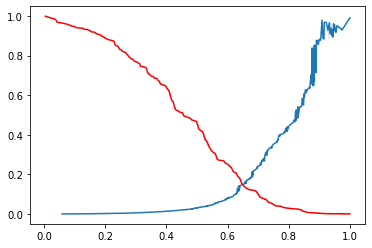

In [26]:
import seaborn as sns
sns.lineplot(precision[:-1], thresholds)
sns.lineplot(recall[:-1], thresholds, color='red')

In [40]:
preds_and_oof[preds_and_oof>0.55].shape[0]/preds_and_oof.shape[0]

0.03760140049806445

In [41]:
preds_and_oof

5758267552716-1-0      0.009675
5758323619399-50-1     0.038574
5758323619364-18-15    0.007673
5758314608564-10-3     0.540857
5758205479573-1-0      0.007927
5758205479331-75-0     0.060162
5758343642863-3-7      0.034601
5758205479630-92-24    0.001259
5758314608434-3-2      0.005298
5758380686738-2-1      0.696516
5758323619179-22-4     0.001092
5758205479527-9-4      0.001061
5758314608617-3-11     0.000311
5758314608645-2-0      0.075279
5758343643224-0-3      0.015957
5758205479305-3-20     0.000212
5758205479246-0-25     0.000073
5758343643012-8-4      0.007459
5758205479331-48-16    0.003814
5758205479431-0-13     0.211268
5758205479165-21-12    0.076898
5758267552716-19-13    0.022472
5758343643245-10-6     0.003103
5758323619314-7-4      0.555582
5758343642974-10-10    0.007883
5758314608764-9-9      0.026338
5758353654677-0-6      0.261495
5758205479249-5-6      0.030625
5758429744857-7-0      0.459764
5758323619369-12-5     0.053619
                         ...   
57583236